In [1]:
%%capture
import sys

# Añade el directorio principal al path de búsqueda para importar módulos desde esa ubicación
sys.path.insert(0, "..")

# Desactivar los warnings para evitar mensajes innecesarios durante la ejecución
import warnings

# Importación de bibliotecas necesarias
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

from likelihood.models.deep import (
    AutoClassifier,
    GetInsights,
)  # Modelos de deep learning personalizados
from likelihood.tools import (
    OneHotEncoder,
    get_metrics,
    PerformanceMeasures,
)  # Herramientas auxiliares

warnings.filterwarnings("ignore")
import tensorflow as tf

import matplotlib.pyplot as plt

plt.rcParams["font.size"] = 10

is_updated = False
from packaging import version

if version.parse(tf.__version__) > version.parse("2.15.0"):
    is_updated = True

E0000 00:00:1755452767.122281   21666 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755452767.126740   21666 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1755452767.138422   21666 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1755452767.138435   21666 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1755452767.138437   21666 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1755452767.138439   21666 computation_placer.cc:177] computation placer already registered. Please check linka

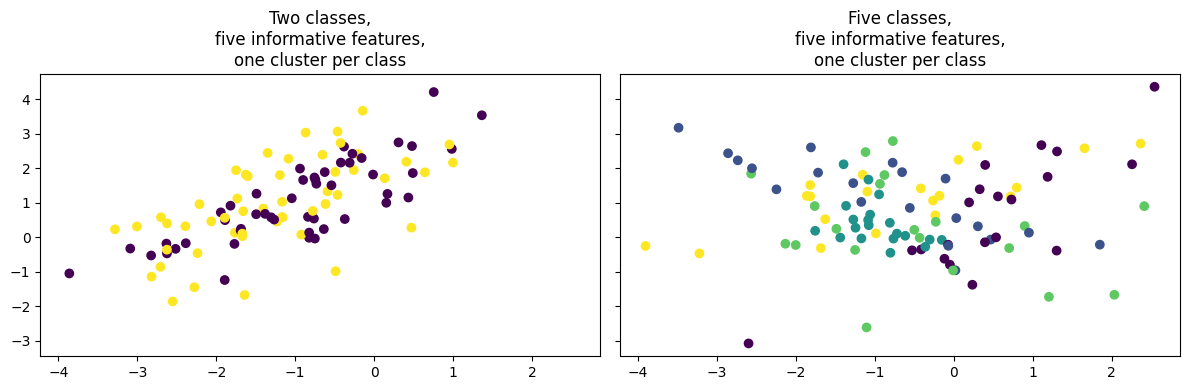

In [2]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharey=True, sharex=True)
titles = [
    "Two classes,\nfive informative features,\none cluster per class",
    "Five classes,\nfive informative features,\none cluster per class",
]
params = [
    {"n_informative": 5, "n_clusters_per_class": 1, "n_classes": 2},
    {"n_informative": 5, "n_clusters_per_class": 1, "n_classes": 5},
]

X_source, Y_source = make_classification(n_features=5, n_redundant=0, random_state=1, **params[0])
axs[0].scatter(X_source[:, 0], X_source[:, 1], c=Y_source)
axs[0].set_title(titles[0])

X_target, Y_target = make_classification(n_features=5, n_redundant=0, random_state=1, **params[1])
axs[1].scatter(X_target[:, 0], X_target[:, 1], c=Y_target)
axs[1].set_title(titles[1])

plt.tight_layout()
plt.show()

In [3]:
# OneHotEncoder convierte las etiquetas a formato one-hot encoding
y_encoder = OneHotEncoder()
Y_source_enc = y_encoder.encode(list(Y_source))
Y_target_enc = y_encoder.encode(list(Y_target))

X_source_train, X_source_test, Y_source_train, Y_source_test = train_test_split(
    X_source, Y_source_enc, test_size=0.2
)
X_target_train, X_target_test, Y_target_train, Y_target_test = train_test_split(
    X_target, Y_target_enc, test_size=0.2
)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Accuracy: 79.00%
Precision: 96.88%
Recall: 60.78%
F1-Score: 74.70
Cohen's Kappa: 0.5830


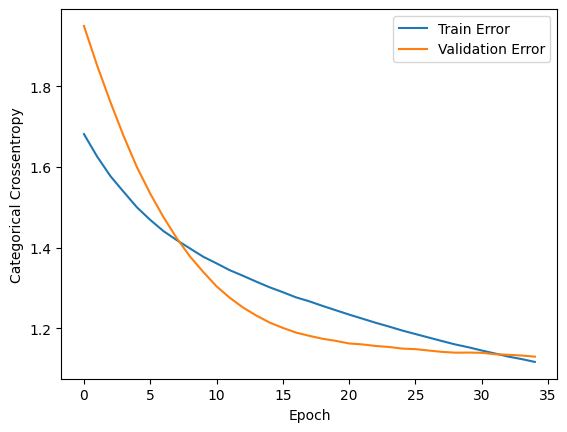

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
       --0-- | --1-- | --2-- | --3-- | --4--
--0--|      4  |      0  |      4  |      2  |      0 
--1--|      0  |     17  |      3  |      7  |      0 
--2--|     10  |      0  |      9  |      1  |      8 
--3--|      6  |      3  |      1  |     10  |      1 
--4--|      0  |      0  |      3  |      0  |     11 
F-measure of label 0 -> 0.2667
F-measure of label 1 -> 0.7234
F-measure of label 2 -> 0.375
F-measure of label 3 -> 0.4878
F-measure of label 4 -> 0.6471
Mean of F-measure -> 0.5


In [4]:
# Create a source model
source_model = AutoClassifier(
    input_shape_parm=X_source.shape[1],
    num_classes=len(np.unique(Y_source)),
    units=16,
    activation="relu",
)

# Compilación del modelo: optimizador, función de pérdida y métricas
source_model.compile(
    optimizer="adam",  # Optimizador Adam
    loss=tf.keras.losses.CategoricalCrossentropy(),  # Función de pérdida para clasificación multiclase
    metrics=[
        tf.keras.metrics.F1Score(threshold=0.5)
    ],  # Métrica F1 (threshold = 0.5 para predicciones)
)

# Entrenar el modelo con los datos, usando 25 épocas y 20% de los datos para validación
source_model.fit(X_source_train, Y_source_train, epochs=25, validation_split=0.2, verbose=False)

# Guardar el modelo entrenado en el disco en formato TensorFlow
if is_updated:
    source_model.save("source_model")
else:
    source_model.save("source_model", save_format="tf")

# Cargar el modelo guardado desde el disco
if is_updated:
    source_model = AutoClassifier.load("source_model")
else:
    source_model = tf.keras.models.load_model("source_model")

# Hacer predicciones sobre el conjunto completo de datos
pred = source_model.predict(X_source)

# Convertir las predicciones a las etiquetas predichas (máxima probabilidad)
pred_label = np.argmax(pred, axis=1)

# Añadir las predicciones al DataFrame para su análisis
df = pd.DataFrame()
df["target"] = Y_source  # Columna de las etiquetas reales
df["prediction"] = pred_label  # Columna de las etiquetas predichas
df["label_0"] = pred[:, 0]  # Probabilidad de la clase 0
df["label_1"] = pred[:, 1]  # Probabilidad de la clase 1

# Calcular y mostrar las métricas del modelo comparando las etiquetas reales y las predicciones
get_metrics(df, "target", "prediction", verbose=True)

# Create a target model with different number of classes
target_model = AutoClassifier(
    input_shape_parm=X_target.shape[1],
    num_classes=len(np.unique(Y_target)),
    units=16,
    activation="selu",
    num_layers=3,
)

# Set the encoder and decoder from the source model to the target model
target_model.set_encoder_decoder(source_model)

# Freeze the encoder and decoder layers in the target model
target_model.freeze_encoder_decoder()

# Compilación del modelo: optimizador, función de pérdida y métricas
target_model.compile(
    optimizer="adam",  # Optimizador Adam
    loss=tf.keras.losses.CategoricalCrossentropy(),  # Función de pérdida para clasificación multiclase
    metrics=[
        tf.keras.metrics.F1Score(threshold=0.5)
    ],  # Métrica F1 (threshold = 0.5 para predicciones)
)

# Entrenar el modelo con los datos, usando 35 épocas y 20% de los datos para validación
history = target_model.fit(
    X_target_train, Y_target_train, epochs=35, validation_split=0.2, verbose=False
)
hist = pd.DataFrame(history.history)
hist["epoch"] = history.epoch


def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist["epoch"] = history.epoch

    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Categorical Crossentropy")
    plt.plot(hist["epoch"], hist["loss"], label="Train Error")
    plt.plot(hist["epoch"], hist["val_loss"], label="Validation Error")
    plt.legend()
    plt.show()


plot_history(history)

# Guardar el modelo entrenado en el disco en formato TensorFlow
target_model.save("target_model", save_format="tf")

# Cargar el modelo guardado desde el disco
if is_updated:
    target_model = AutoClassifier.load("target_model")
else:
    target_model = tf.keras.models.load_model("target_model")

# Hacer predicciones sobre el conjunto completo de datos
pred = target_model.predict(X_target)

# Convertir las predicciones a las etiquetas predichas (máxima probabilidad)
pred_label = np.argmax(pred, axis=1)

labels = list(np.unique(Y_target))

helper = PerformanceMeasures()
helper._summary_pred(Y_target, pred_label, labels)
_ = helper._f1_score(Y_target, pred_label, labels)
_ = helper.f_mean(Y_target, pred_label, labels)

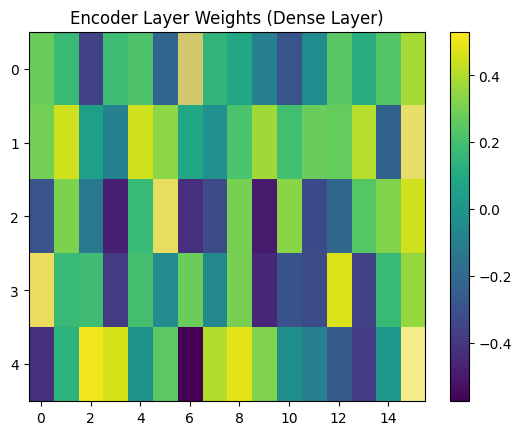

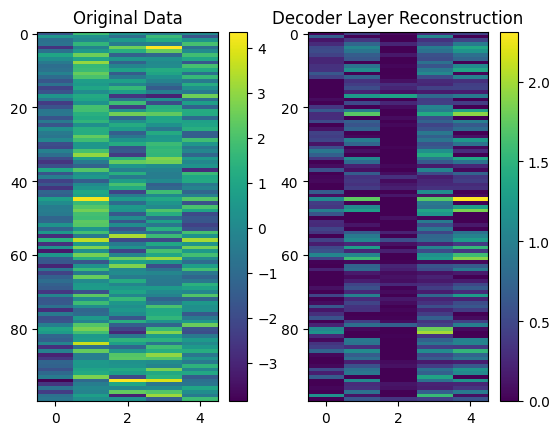

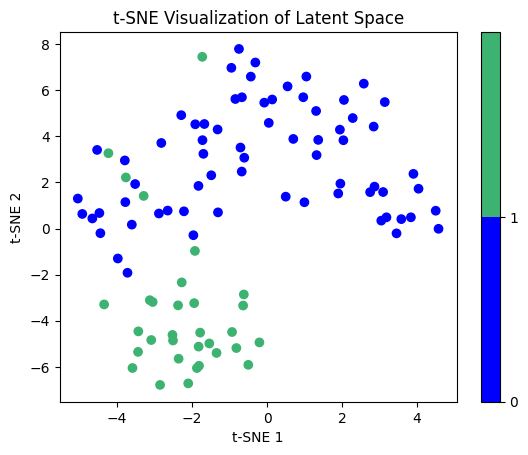

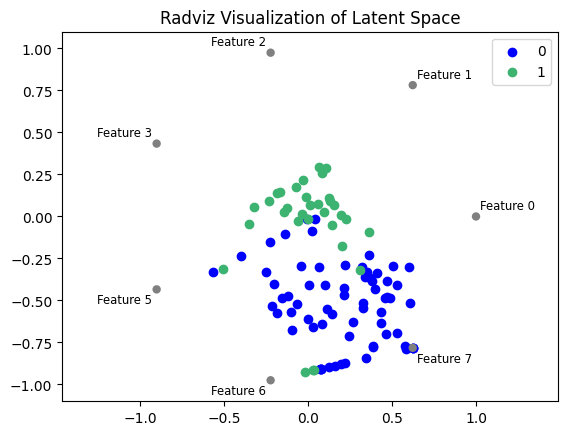

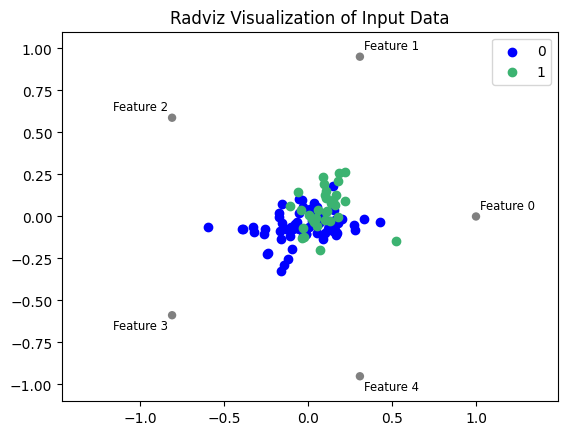

In [5]:
insights_source = GetInsights(source_model, X_source)
summary = insights_source.predictor_analyzer()

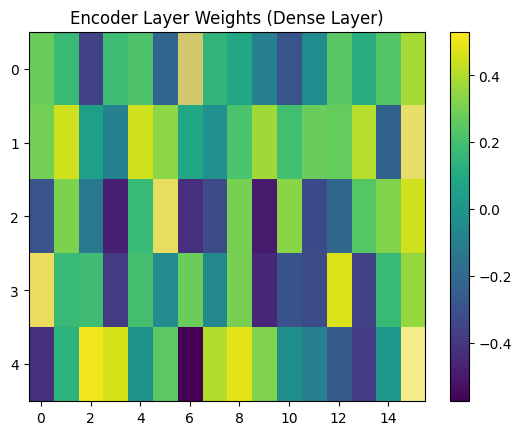

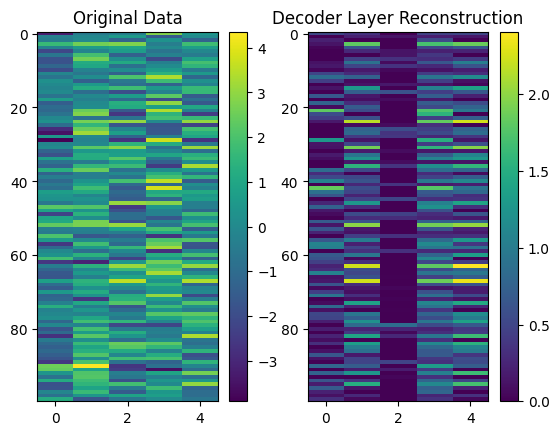

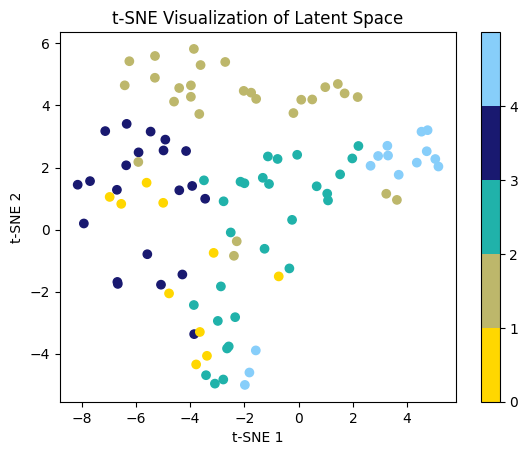

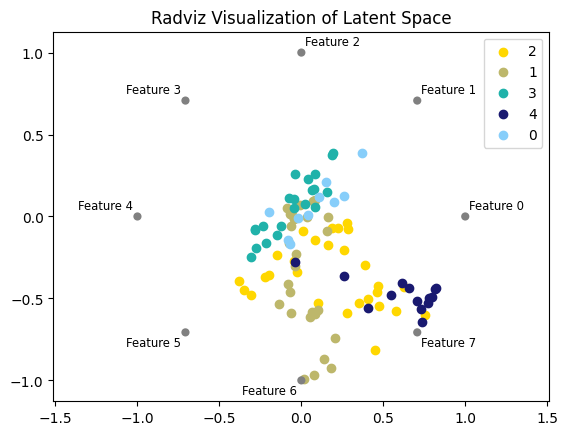

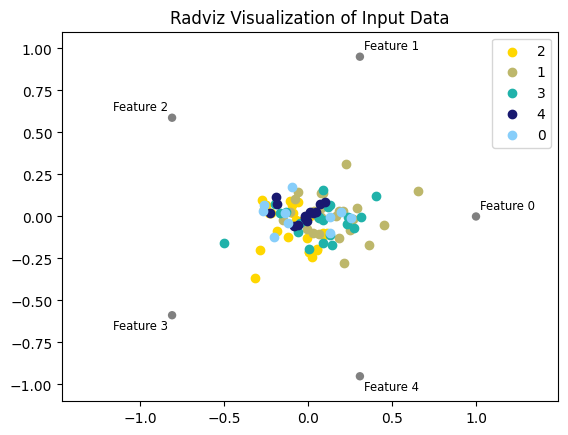

In [6]:
insights_target = GetInsights(target_model, X_target)
summary = insights_target.predictor_analyzer()

In [7]:
target_model.summary()

=== AutoClassifier Summary ===

--- Encoder ---


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_dense_1 (Dense)         │ (None, 16)             │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_dense_2 (Dense)         │ (None, 8)              │           136 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 232 (928.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 232 (928.00 B)


--- Decoder ---


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_dense_1 (Dense)         │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_dense_2 (Dense)         │ (None, 5)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 229 (916.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 229 (916.00 B)


--- Classifier ---


Model: "classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ classifier_input (InputLayer)   │ (None, 13)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classifier_dense_1 (Dense)      │ (None, 16)             │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classifier_dense_2 (Dense)      │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classifier_output (Dense)       │ (None, 5)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 581 (2.27 KB)

 Trainable params: 581 (2.27 KB)

 Non-trainable params: 0 (0.00 B)


--- Main Model ---


Model: "auto_classifier_main"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ main_input          │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder             │ (None, 8)         │        232 │ main_input[0][0]  │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder             │ (None, 5)         │        229 │ encoder[0][0]     │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ combine_features    │ (None, 13)        │          0 │ decoder[0][0],    │
│ (Concatenate)       │                   │            │ encoder[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ classifier          │ (None, 5)         │        581 │ combine_features… │
│ (Functional)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,206 (8.62 KB)

 Trainable params: 581 (2.27 KB)

 Non-trainable params: 461 (1.80 KB)

 Optimizer params: 1,164 (4.55 KB)

In [8]:
source_model.summary()

=== AutoClassifier Summary ===

--- Encoder ---


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_dense_1 (Dense)         │ (None, 16)             │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_dense_2 (Dense)         │ (None, 8)              │           136 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 232 (928.00 B)

 Trainable params: 232 (928.00 B)

 Non-trainable params: 0 (0.00 B)


--- Decoder ---


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_dense_1 (Dense)         │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_dense_2 (Dense)         │ (None, 5)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 229 (916.00 B)

 Trainable params: 229 (916.00 B)

 Non-trainable params: 0 (0.00 B)


--- Classifier ---


Model: "classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ classifier_input (InputLayer)   │ (None, 13)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classifier_output (Dense)       │ (None, 2)              │            28 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28 (112.00 B)

 Trainable params: 28 (112.00 B)

 Non-trainable params: 0 (0.00 B)


--- Main Model ---


Model: "auto_classifier_main"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ main_input          │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder             │ (None, 8)         │        232 │ main_input[0][0]  │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder             │ (None, 5)         │        229 │ encoder[0][0]     │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ combine_features    │ (None, 13)        │          0 │ decoder[0][0],    │
│ (Concatenate)       │                   │            │ encoder[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ classifier          │ (None, 2)         │         28 │ combine_features… │
│ (Functional)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,469 (5.74 KB)

 Trainable params: 489 (1.91 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 980 (3.83 KB)

In [9]:
# Verificar si encoder y decoder de target son iguales a los de source
assert np.array_equal(
    source_model.encoder.get_weights()[0], target_model.encoder.get_weights()[0]
), "Encoder no es igual"
assert np.array_equal(
    source_model.decoder.get_weights()[0], target_model.decoder.get_weights()[0]
), "Decoder no es igual"

In [10]:
from tensorflow.keras.utils import plot_model

# Plot the model architecture
plot_model(
    target_model.classifier,
    to_file="architecture_model.png",
    show_shapes=True,
    show_layer_names=True,
)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.
